## Data Science for Algorthmmic Trading
### Part 3

- 참고자료 : https://towardsdatascience.com/data-science-in-algorithmic-trading-d21a46d1565d

<div style="text-align: right"> Initial upload: 2020.07.30 </div>
<div style="text-align: right"> Last update: 2020.07.30 </div>

**위 참고자료의 내용을 번역, 필사하고, 일부 내용을 추가한 것이다.**    
여기서는 지도학습 기반의 환율예측 모델을 만들기 전에 타겟과 피처간의 상관도를 분석해본다.
- 입력은 IPPI 데이터, 그리고 출력은 USD_CAD 예측 값이다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 20

### 1. IPPI 데이터 import  
- Part2에서 전처리한 IPPI 데이터를 가져온다.

In [2]:
df = pd.read_csv('forex_signals.csv')

In [3]:
df.head()

,REF_DATE,North American Product Classification System (NAPCS),VALUE,"Total, Industrial product price index (IPPI)",Energy and petroleum products [P51],Natural gas liquids and related products [143],"Solid fuel products, not elsewhere classified [144]","Refined petroleum energy products, and biofuels [261]",Coke and other coke oven products [26111],Motor gasoline [26121],...,Cut diamonds (except industrial),"Cut gems (except diamonds), jewellery findings, and metal coins and tokens",Precious metal hollowware and flatware,Costume jewellery and novelties,Musical instruments (including parts and accessories),Other miscellaneous goods,"Buttons, zippers and other notions","Brooms, mops, dusters, and brushes, and painting pads, rollers and accessories","Other miscellaneous goods, not elsewhere classified","Unrecorded optical and magnetic media, and media not elsewhere classified"
0,1956-01,NaN,NaN,15.6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1956-02,NaN,NaN,15.6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1956-03,NaN,NaN,15.7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1956-04,NaN,NaN,15.7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1956-05,NaN,NaN,15.8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. 데이터 전처리  

In [4]:
# 특정 연도구간의 데이터 추출하는 코드
for startYear,endYear in [[1949,2019],[1990,2000],[2000,2010],[2010,2019]]:
    df_new = pd.read_csv('forex_signals.csv',index_col=0)
    # Keep only the data for the time range that we care about
    if startYear>=1950:
        df_new = df_new[df_new.index>=str(startYear)+'-01']
        df_new = df_new[df_new.index<str(endYear)+'-01']
      # Use the same date format we used for the exchange rate
    df_new.index=pd.to_datetime(df_new.index)

In [5]:
df_new #여기서는 2010 ~ 2018년 데이터가 추출 될 것이다.

,North American Product Classification System (NAPCS),VALUE,"Total, Industrial product price index (IPPI)",Energy and petroleum products [P51],Natural gas liquids and related products [143],"Solid fuel products, not elsewhere classified [144]","Refined petroleum energy products, and biofuels [261]",Coke and other coke oven products [26111],Motor gasoline [26121],"Motor gasoline, regular",...,Cut diamonds (except industrial),"Cut gems (except diamonds), jewellery findings, and metal coins and tokens",Precious metal hollowware and flatware,Costume jewellery and novelties,Musical instruments (including parts and accessories),Other miscellaneous goods,"Buttons, zippers and other notions","Brooms, mops, dusters, and brushes, and painting pads, rollers and accessories","Other miscellaneous goods, not elsewhere classified","Unrecorded optical and magnetic media, and media not elsewhere classified"
REF_DATE,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,99.1,99.1,118.7,90.8,99.2,90.8,98.3,98.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-01,NaN,NaN,99.0,97.7,115.9,91.3,97.5,91.3,97.9,97.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-01,NaN,NaN,99.0,99.9,100.1,88.7,100.2,88.7,101.4,101.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-01,NaN,NaN,99.5,100.6,93.1,90.5,101.1,90.5,102.1,102.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-01,NaN,NaN,99.9,98.6,87.8,93.6,98.4,93.6,99.4,99.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,NaN,NaN,118.7,129.9,47.9,161.4,130.6,161.4,130.7,129.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-01,NaN,NaN,118.9,130.9,53.1,158.6,131.8,158.6,130.1,129.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-01,NaN,NaN,119.1,131.3,55.5,171.5,131.6,171.5,125.0,123.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


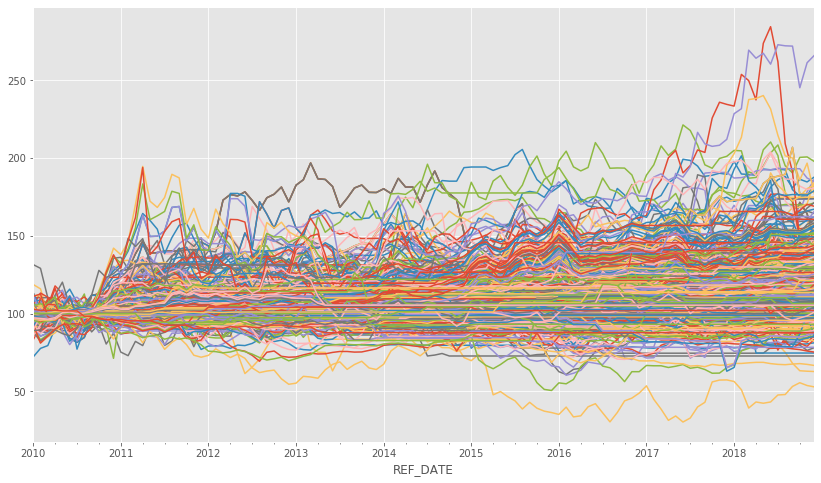

In [6]:
df_new.plot(figsize = (14, 8), legend = False)

데이터 스케일링 : MinMaxScaler

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()

In [9]:
# df_new = scaler.fit_transform(df_new) : 결과로 numpy를 리턴함

In [10]:
df_new[df_new.columns] = scaler.fit_transform(df_new)

In [11]:
df_new.head()

,North American Product Classification System (NAPCS),VALUE,"Total, Industrial product price index (IPPI)",Energy and petroleum products [P51],Natural gas liquids and related products [143],"Solid fuel products, not elsewhere classified [144]","Refined petroleum energy products, and biofuels [261]",Coke and other coke oven products [26111],Motor gasoline [26121],"Motor gasoline, regular",...,Cut diamonds (except industrial),"Cut gems (except diamonds), jewellery findings, and metal coins and tokens",Precious metal hollowware and flatware,Costume jewellery and novelties,Musical instruments (including parts and accessories),Other miscellaneous goods,"Buttons, zippers and other notions","Brooms, mops, dusters, and brushes, and painting pads, rollers and accessories","Other miscellaneous goods, not elsewhere classified","Unrecorded optical and magnetic media, and media not elsewhere classified"
REF_DATE,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,0.004831,0.245315,0.826331,0.019409,0.266975,0.019409,0.272036,0.289121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-01,NaN,NaN,0.000000,0.221465,0.800187,0.024030,0.240741,0.024030,0.265957,0.284650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-01,NaN,NaN,0.000000,0.258944,0.652661,0.000000,0.282407,0.000000,0.319149,0.336811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-01,NaN,NaN,0.024155,0.270869,0.587302,0.016636,0.296296,0.016636,0.329787,0.348733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-01,NaN,NaN,0.043478,0.236797,0.537815,0.045287,0.254630,0.045287,0.288754,0.305514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


환율 데이터와 합치기

In [12]:
rates = pd.read_csv('rates.csv', index_col=['REF_DATE'], 
                   parse_dates=['REF_DATE'])

In [13]:
rates.head()

,USD_CAD
REF_DATE,
1950-10-02,1.05500
1950-10-03,1.05000
1950-10-04,1.05250
1950-10-05,1.06000
1950-10-06,1.05875


In [14]:
merged = df_new.join(rates, how = 'inner').fillna(value = 0)

In [15]:
merged.head()

,North American Product Classification System (NAPCS),VALUE,"Total, Industrial product price index (IPPI)",Energy and petroleum products [P51],Natural gas liquids and related products [143],"Solid fuel products, not elsewhere classified [144]","Refined petroleum energy products, and biofuels [261]",Coke and other coke oven products [26111],Motor gasoline [26121],"Motor gasoline, regular",...,"Cut gems (except diamonds), jewellery findings, and metal coins and tokens",Precious metal hollowware and flatware,Costume jewellery and novelties,Musical instruments (including parts and accessories),Other miscellaneous goods,"Buttons, zippers and other notions","Brooms, mops, dusters, and brushes, and painting pads, rollers and accessories","Other miscellaneous goods, not elsewhere classified","Unrecorded optical and magnetic media, and media not elsewhere classified",USD_CAD
REF_DATE,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0.0,0.0,0.004831,0.245315,0.826331,0.019409,0.266975,0.019409,0.272036,0.289121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0510
2010-02-01,0.0,0.0,0.000000,0.221465,0.800187,0.024030,0.240741,0.024030,0.265957,0.284650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0624
2010-03-01,0.0,0.0,0.000000,0.258944,0.652661,0.000000,0.282407,0.000000,0.319149,0.336811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0416
2010-04-01,0.0,0.0,0.024155,0.270869,0.587302,0.016636,0.296296,0.016636,0.329787,0.348733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0084
2010-05-01,0.0,0.0,0.043478,0.236797,0.537815,0.045287,0.254630,0.045287,0.288754,0.305514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0158


### 3. 상관도 분석

상관도 계산하기: 타겟인 USD_CAD와의 상관도를 계산한다.

In [16]:
corr = merged.corr()['USD_CAD'].sort_values(ascending = False).dropna()

상관도 시각화 하기

In [17]:
def makeFig(plt, title, xlabel, ylabel, fName):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fName, dpi=100)
    #plt.show()
    return

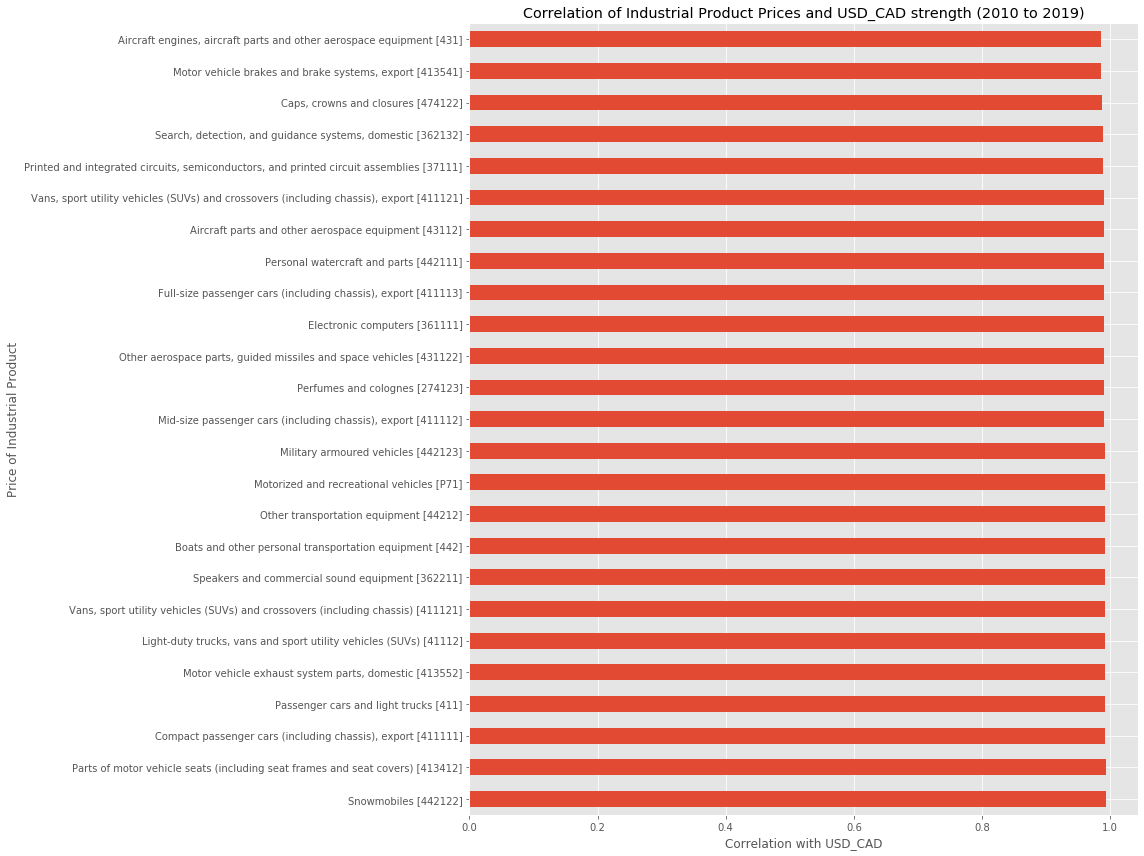

In [18]:
# 높은 상관도를 보이는 25개만 살펴본다.
plt.figure(figsize=(16, 12))
corr[1:26].plot.barh() # 자기상관도를 제외한 25개
title="Correlation of Industrial Product Prices and USD_CAD strength ("+str(startYear)+" to "+str(endYear)+")"
xlabel="Correlation with USD_CAD"
ylabel="Price of Industrial Product"
fName=str(startYear)+'s_corr_high.png'
makeFig(plt, title, xlabel, ylabel, fName)

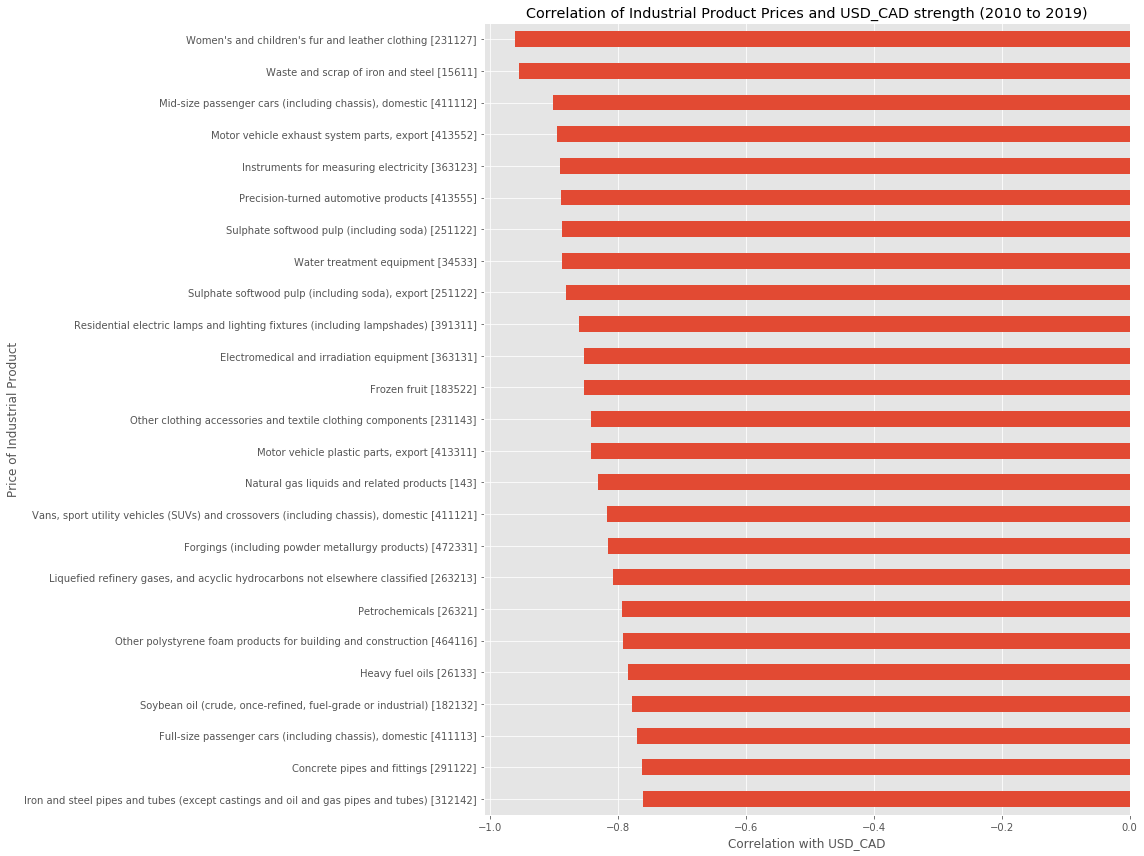

In [19]:
# 낮은 상관도를 보이는 25개 살펴보기
plt.figure(figsize=(16, 12))
corr[-25:].plot.barh()
fName=str(startYear)+'s_corr_low.png'
makeFig(plt, title, xlabel, ylabel, fName)

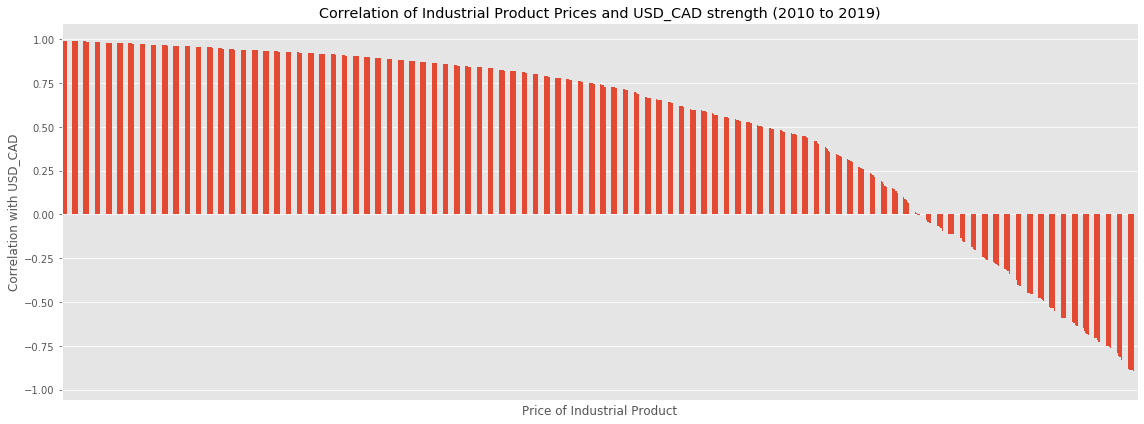

In [20]:
plt.figure(figsize=(16, 6))
corr[1:].plot.bar()
plt.xticks([])  
fName=str(startYear)+'s_histogram_correlations.png'
makeFig(plt, title, ylabel, xlabel, fName)

환율 상승에 영향을 미치는 인자 찾기  
- 먼저 환율 변동분('dUSD_CAD') 컬럼을 생성하고, 이 컬럼과 다른 피처와의 상관도를 살펴본다.

In [21]:
merged['dUSD_CAD'] = merged['USD_CAD'].shift(-1) -merged['USD_CAD'] # 환율 변동분
corr2 = merged.corr()['dUSD_CAD'].sort_values(ascending=False).dropna

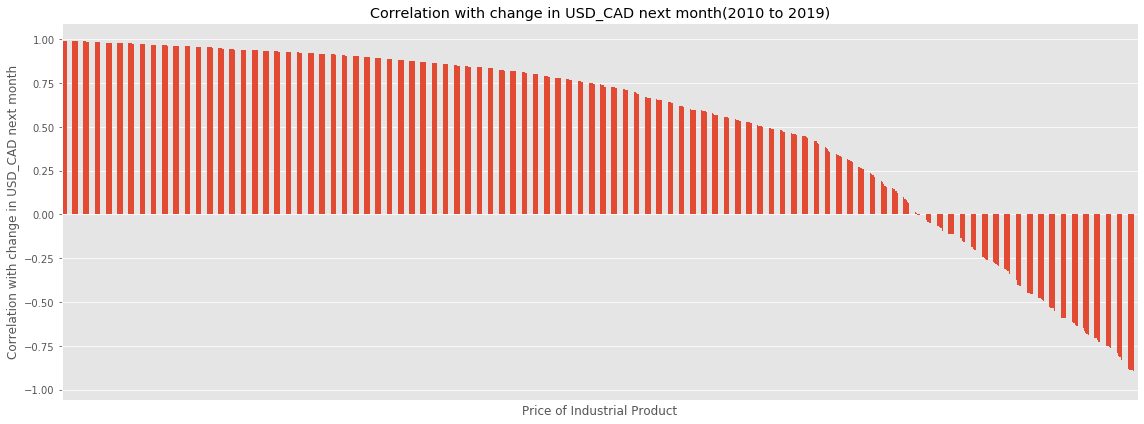

In [22]:
# 환율 상승에 상관성이 높은 인자 찾기
plt.figure(figsize=(16, 6))
corr[1:].plot.bar()
plt.xticks([])
xlabel="Price of Industrial Product"
ylabel="Correlation with change in USD_CAD next month"
title="Correlation with change in USD_CAD next month("+str(startYear)+" to "+str(endYear)+")"
fName=str(startYear)+'s_histogram_predictions.png'
makeFig(plt, title, xlabel, ylabel, fName)

전구간 살펴보기 : 1949 ~ 2019

In [23]:
# 1950 ~ 2019년 구간 살펴보기
startYear = 1949
endYear = 2019
df_new = pd.read_csv('forex_signals.csv',index_col=0)

df_new.index=pd.to_datetime(df_new.index)

In [24]:
merged = df_new.join(rates, how = 'inner').fillna(value = 0)

In [25]:
corr = merged.corr()['USD_CAD'].sort_values(ascending = False).dropna()

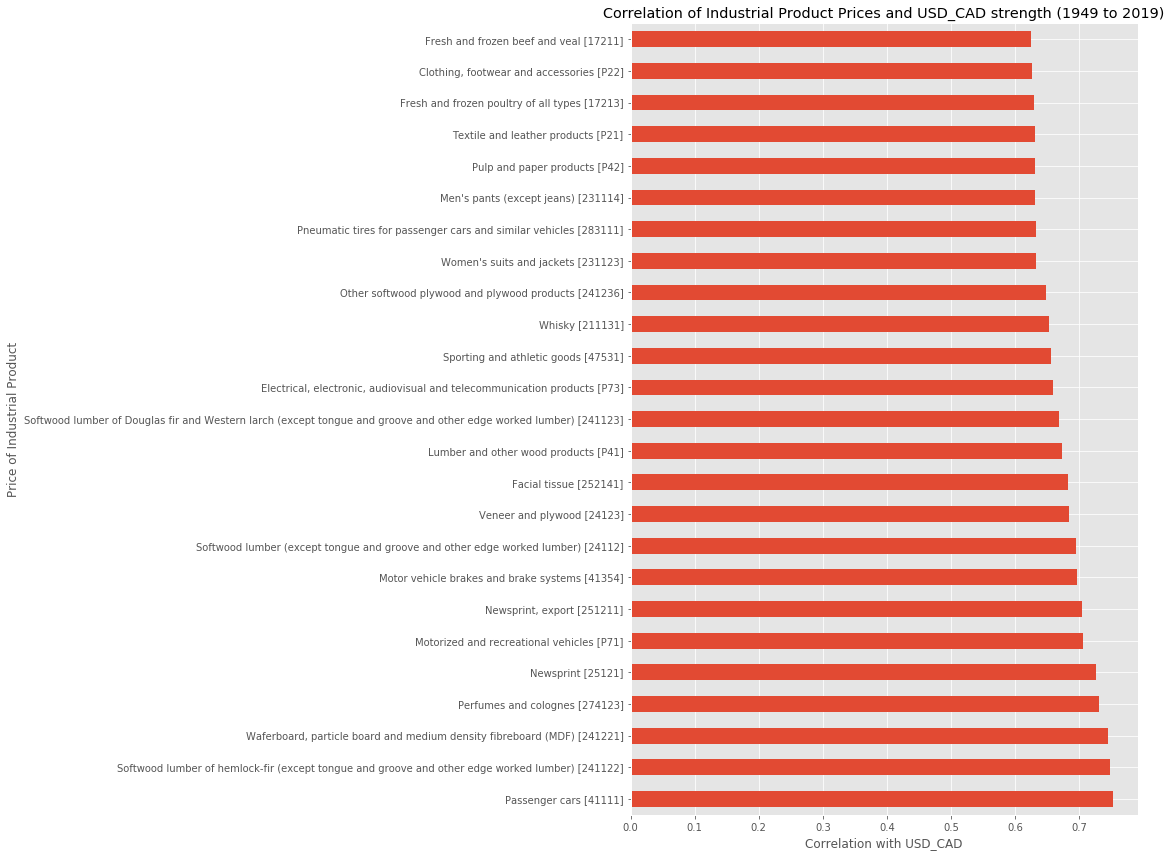

In [26]:
# 높은 상관도를 보이는 25개만 살펴본다.
plt.figure(figsize=(16, 12))
corr[1:26].plot.barh() # 자기상관도를 제외한 25개
title="Correlation of Industrial Product Prices and USD_CAD strength ("+str(startYear)+" to "+str(endYear)+")"
xlabel="Correlation with USD_CAD"
ylabel="Price of Industrial Product"
fName=str(startYear)+'s_corr_high.png'
makeFig(plt, title, xlabel, ylabel, fName)

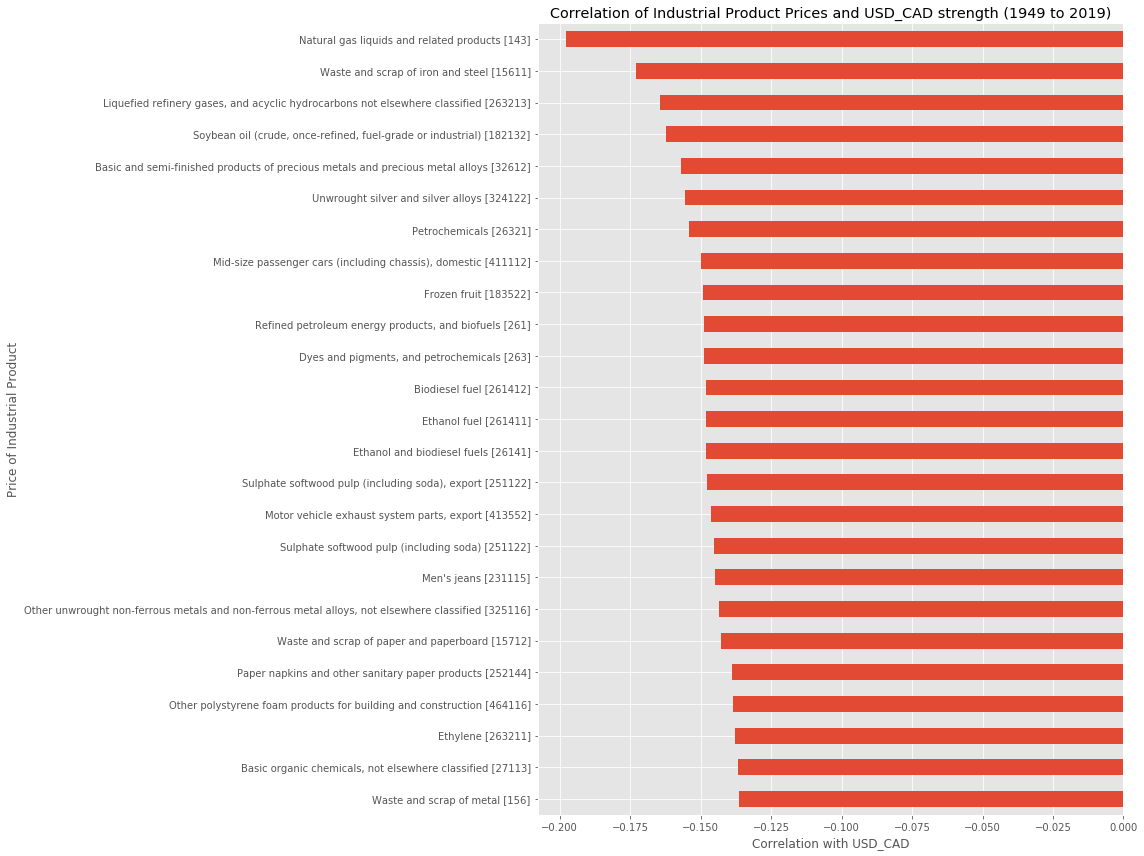

In [27]:
# 낮은 상관도를 보이는 25개 살펴보기
plt.figure(figsize=(16, 12))
corr[-25:].plot.barh()
fName=str(startYear)+'s_corr_low.png'
makeFig(plt, title, xlabel, ylabel, fName)

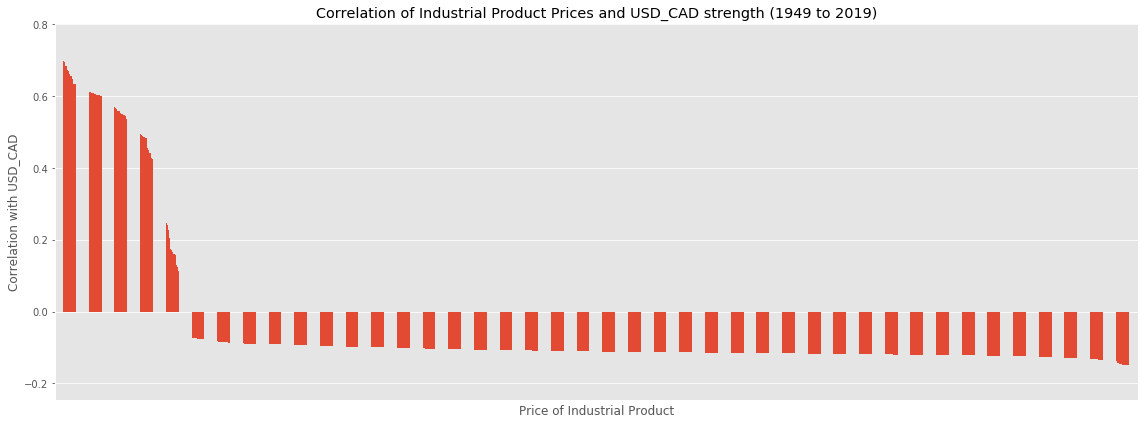

In [28]:
plt.figure(figsize=(16, 6))
corr[1:].plot.bar()
plt.xticks([])  
fName=str(startYear)+'s_histogram_correlations.png'
makeFig(plt, title, ylabel, xlabel, fName)